In [1]:
!pip install -Uqq fastai

In [2]:
!pip install -Uqq duckduckgo_search

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import * 

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=term)       
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

from pathlib import Path
import hashlib

def get_file_hash(file_path):
    """Compute MD5 hash of the file content."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def remove_duplicates(image_paths):
    """Remove duplicate images based on file content."""
    hashes = {}
    duplicates = []
    for path in image_paths:
        file_hash = get_file_hash(path)
        if file_hash in hashes:
            duplicates.append(path)
        else:
            hashes[file_hash] = path
    return duplicates

In [4]:
urls = search_images('parrot evening photos', max_images=1)
print(urls[0])

Searching for 'parrot evening photos'
https://i.pinimg.com/originals/21/e0/af/21e0afd65f78a2dfad52261b432d9387.jpg


C:\Users\alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\curl_cffi\aio.py:192: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")
C:\Users\alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\curl_cffi\aio.py:192: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")


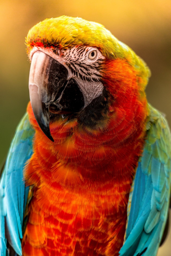

In [5]:
from fastdownload import download_url 
dest = 'parrot.jpg' 
download_url(urls[0], dest, show_progress=False) 

from fastai.vision.all import * 
im = Image.open(dest) 
im.to_thumb(256,256)

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=true) 
Image.open('forest.jpg').to_thumb(256,256)

Searching for 'forest photos'


In [ ]:
searches = 'forest','parrot' 
path = Path('parrot_or_not') 

from time import sleep 
for o in searches: 
    dest = (path/o) 
    dest.mkdir(exist_ok=True, parents=True) 
    download_images(dest, urls=search_images(f'{o} photo')) 
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun photo')) 
    sleep(10) 
    download_images(dest, urls=search_images(f'{o} evening photo')) 
    sleep(10) 
    download_images(dest, urls=search_images(f'{o} shade photo')) 
    sleep(10) 
    resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
failed = verify_images(get_image_files(path)) 
failed.map(Path.unlink) 
print(len(failed))

# Remove duplicate images
duplicates = remove_duplicates(get_image_files(path))
for file in duplicates:
    Path(file).unlink()

print(len(duplicates))

In [ ]:
dls = DataBlock( 
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, 
    item_tfms=[Resize(192, method='squish')] 
).dataloaders(path) 

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate) 
learn.fine_tune(5)

In [ ]:
learn.show_results()

is_bird,_,probs = learn.predict(PILImage.create('p.jpg')) 
print(f"This is a: {is_bird}.") 
print(f"Probability it's a forest: {probs[0]:.5f}")